In [4]:
%pip install matplotlib
%pip install pandas
%pip install pint


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import pint

In [6]:
ureg = pint.UnitRegistry()

In [7]:
def make_line_better(json):
    if "cpu_atom" in json["event"]:
        return None
    if "instructions" in json["event"]:
        return ("instructions", float(json["counter-value"]), float(json["variance"]))
    if "cycles" in json["event"]:
        return ("cycles", float(json["counter-value"]), float(json["variance"]))
    if "task-clock" in json["event"]:
        t = ureg(json["counter-value"] + " " + json["unit"]).to(ureg("s")).magnitude
        factor = ureg("1 " + json["unit"]).to(ureg("s")).magnitude
        var = float(json["variance"]) * factor * factor
        return ("time", t, var)
    print("Unhandled event: " + json["event"])
    return None

In [8]:
# read the data
def read_qemu_patched(values):
    filenames = map(lambda x: (x, f"qemu_patched_{x}.json"), values)
    vals = []
    for (nbnops, filename) in filenames:
        with open(filename, 'r') as f:
            temp = []
            for line in f:
                line = json.loads(line)
                line = make_line_better(line)
                if line is not None:
                    temp.append(line)
            
            temp.sort(key=lambda x: x[0])
            temp = [item for tup in temp for item in tup[1:]]
            vals.append(temp)
    return (values, vals)

def read_qemu(values):
    filenames = map(lambda x: (x, f"qemu_{x}.json"), values)
    vals = []
    for (nbnops, filename) in filenames:
        with open(filename, 'r') as f:
            temp = []
            for line in f:
                line = json.loads(line)
                line = make_line_better(line)
                if line is not None:
                    temp.append(line)
            
            temp.sort(key=lambda x: x[0])
            temp = [item for tup in temp for item in tup[1:]]
            vals.append(temp)
    return (values, vals)

def read_qemu_tb_stats(values):
    filenames = map(lambda x: (x, f"qemu_tblog_{x}.json"), values)
    vals = []
    for (nbnops, filename) in filenames:
        with open(filename, 'r') as f:
            temp = json.load(f)
            temp = temp[:-1]
            (execs, translations) = (filter(lambda x: x["type"] == "exec", temp), filter(lambda x: x["type"] == "trans", temp))
            (execs, translations) = (list(execs), list(translations))
            nbExecs = len(execs)
            nbTranslations = len(translations)
            
            executedInstructions = list(map(lambda x: x["n_insn"], execs))
            translatedInstructions = list(map(lambda x: x["n_insn"], translations))
            vals.append((nbExecs, nbTranslations, executedInstructions, translatedInstructions))
    
    return (values, zip(*vals))

In [9]:
(indices, (nbTbExec, nbTranslations, executedInstructions, translatedInstructions)) = read_qemu_tb_stats(range(0, 10001, 1000))
print(nbTbExec)
print(nbTranslations)
print(executedInstructions)
print(translatedInstructions)

(1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20)
(1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20)
([3], [512, 491], [512, 512, 512, 467], [512, 512, 512, 512, 512, 443], [512, 512, 512, 512, 512, 512, 512, 419], [512, 512, 512, 512, 512, 512, 512, 512, 512, 395], [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 371], [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 347], [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 323], [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 299], [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 275])
([3], [512, 491], [512, 512, 512, 467], [512, 512, 512, 512, 512, 443], [512, 512, 512, 512, 512, 512, 512, 419], [512, 512, 512, 512, 512, 512, 512, 512, 512, 395], [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 371], [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 347], [512, 512, 512, 512, 512, 512, 512, 512, 512

In [10]:
def get_benchmark_cases():
    import os
    import re

    # Regex to match files with the pattern "qemu_{number}.json"
    pattern = re.compile(r'qemu_(\d+)\.json')
    numbers = []

    # Traverse the directory
    for root, _, files in os.walk("./"):
        for filename in files:
            match = pattern.match(filename)
            if match:
                # Extract the number part and add to the list as integer
                numbers.append(int(match.group(1)))

    return sorted(numbers)

In [21]:
(indices, patched_data) = read_qemu_patched(get_benchmark_cases())
patched_data = pd.DataFrame(patched_data, index=indices, columns=["instructions", "instructions_var", "cycles", "cycles_var", "time", "time_var"])
display(patched_data)

(indices, data) = read_qemu(get_benchmark_cases())
data = pd.DataFrame(data, index=indices, columns=["instructions", "instructions_var", "cycles", "cycles_var", "time", "time_var"])
data

,instructions,instructions_var,cycles,cycles_var,time,time_var
0,4893586.0,0.11,7882337.0,0.0,0.003213,1.500000e-07
1000,4956513.0,0.06,8803658.0,0.0,0.003194,1.500000e-07
2000,5274632.0,0.07,9742118.0,0.0,0.003273,1.500000e-07
3000,5530273.0,0.07,10680825.0,0.0,0.003338,1.500000e-07
4000,5663676.0,0.04,11619682.0,0.0,0.003359,1.600000e-07
5000,6068699.0,0.07,12561068.0,0.0,0.003480,1.500000e-07
6000,6272664.0,0.06,13500015.0,0.0,0.003514,1.600000e-07
7000,6572991.0,0.06,14438955.0,0.0,0.003543,1.400000e-07
8000,6740485.0,0.05,15377915.0,0.0,0.003612,1.500000e-07
9000,7027605.0,0.05,16319140.0,0.0,0.003690,1.500000e-07


,instructions,instructions_var,cycles,cycles_var,time,time_var
0,4839815.0,0.08,7938915.0,0.0,0.003156,1.500000e-07
1000,5204614.0,0.09,9367258.0,0.0,0.003312,1.700000e-07
2000,5526784.0,0.06,10655077.0,0.0,0.003367,1.500000e-07
3000,5954482.0,0.07,11943041.0,0.0,0.003494,1.500000e-07
4000,6178557.0,0.06,13231334.0,0.0,0.003525,1.600000e-07
5000,6542884.0,0.06,14522102.0,0.0,0.003614,1.500000e-07
6000,6929699.0,0.07,15810468.0,0.0,0.003716,1.500000e-07
7000,7568648.0,0.12,17098774.0,0.0,0.003858,1.400000e-07
8000,7647974.0,0.08,18387012.0,0.0,0.003858,1.400000e-07
9000,7922597.0,0.07,19677586.0,0.0,0.003932,1.500000e-07


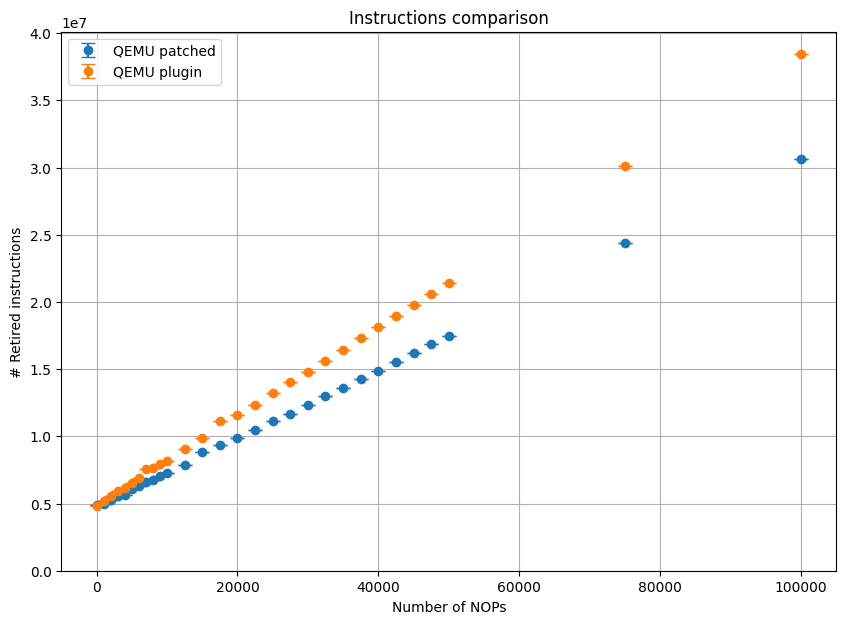

In [22]:
def plot(data, data_patched):
    # Plot "instructions" with variance
    plt.figure(figsize=(10, 7))

    # Plot "instructions" with variance for both instr_var and cycles_var
    plt.errorbar(data_patched.index, data_patched['instructions'], 
             yerr=data_patched['instructions_var'], fmt='o', label='QEMU patched', capsize=5)
    plt.errorbar(data_patched.index, data['instructions'],
               yerr=data['instructions_var'], fmt='o', label='QEMU plugin', capsize=5)
    plt.ylabel('# Retired instructions')
    plt.title('Instructions comparison')
    plt.legend()
    plt.grid()
    # logscale
    plt.ylim(bottom=0)
    plt.xlabel("Number of NOPs")
plot(data, patched_data)